In [1]:
# Quick work around to import packages in the parent directory
import sys
sys.path.insert(0,'..')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from timeit import default_timer as timer
from sklearn.utils import resample
import matplotlib.pyplot as plt
from matrixMath import Knotilus
import pandas as pd
import numpy as np

In [16]:
def alphaloopComp_boot(data, iters, split, verbose=False):
    fullVariable = np.array(data[0])
    fullTarget   = np.array(data[1])

    results = []
    bestResults = {}
    methods = ({'method': 'SLSQP', 'alphaLoop' : True},
               {'method': 'SLSQP', 'alphaLoop' : False},
               {'method': 'constrained', 'alphaLoop' : False})
    for i in range(iters):
        if verbose:
            print('Iteration:', i)

        trainIndices = resample(np.arange(fullVariable.shape[0]), replace=True, n_samples=int(fullVariable.shape[0] * split))
        testIndices = np.array([ind for ind in np.arange(fullVariable.shape[0]) if ind not in trainIndices])
        X_train = fullVariable[trainIndices]
        y_train = fullTarget[trainIndices]
        X_test  = fullVariable[testIndices]
        y_test  = fullTarget[testIndices]

        for method in methods:
            if verbose:
                print('Running', method)
            start = timer()

            model = Knotilus(X_train, y_train)
            model = model.fit(optim=method['method'], numKnots='auto', alphaLoop=method['alphaLoop'], verbose=False)

            end = timer()

            model.errFunc  = model.RMSE
            model.variable = X_test
            model.target   = y_test

            test_rmse = model.error(model.knotLoc)

            result = {
                'iteration' : i,
                'test-rmse' : test_rmse,
                'numKnots' : model.numKnots,
                'knotLoc'  : model.knotLoc,
                'iterations' : model.iterations,
                'time' : end-start
            }

            if method['method'] == 'SLSQP' and method['alphaLoop']:
                result['method'] = 'Alphaloop'
            elif method['method'] == 'SLSQP' and not method['alphaLoop']:
                result['method'] = 'Unconstrained'
            else:
                result['method'] = 'Constrained'

            if method['method'] not in bestResults.keys() or result['test-rmse'] < bestResults[method['method']]['test-rmse']:
                bestResults[method['method']] = result

            results.append(result)

    return (bestResults, results)

In [17]:
df = pd.read_csv('../data/us_covid19_daily.csv')
df['deathIncrease'] = df['deathIncrease'].astype(int)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['unixTime'] = df['date'].astype(int) / 10**9
df = df[['unixTime', 'deathIncrease']]

ss  = MinMaxScaler()
foo = ss.fit_transform(df)
covid = pd.DataFrame(foo)

df = pd.read_csv('../data/Bike-Sharing-Dataset/day.csv')
df = df[['temp', 'cnt']]

ss  = MinMaxScaler()
foo = ss.fit_transform(df)
bike = pd.DataFrame(foo)

df = pd.read_csv('../data/pw_data3_1000.csv')
ss  = MinMaxScaler()
foo = ss.fit_transform(df)
synthetic_500 = pd.DataFrame(foo)

df = pd.read_csv('../data/pw_data3_5000.csv')
ss  = MinMaxScaler()
foo = ss.fit_transform(df)
synthetic_5k = pd.DataFrame(foo)

In [18]:
datasets = [
    {'name' : 'Covid', 'data': covid},
    {'name' : 'Bike', 'data': bike},
    {'name' : 'Synthetic_500', 'data': synthetic_500},
    {'name' : 'Synthetic_5k', 'data': synthetic_5k}
]

In [19]:
for dataset in datasets:
    dataset['results'] = alphaloopComp_boot(dataset['data'], 5, .9)

In [20]:
for dataset in datasets:
    df_best = pd.DataFrame.from_dict(dataset['results'][0], orient='index')
    df_all = pd.DataFrame.from_records(dataset['results'][1])

    df_all.to_csv(f"../data/results/alphaloop_comp_{dataset['name'].capitalize()}_all.csv", index=False)
    df_best.to_csv(f"../data/results/alphaloop_comp_{dataset['name'].capitalize()}_best.csv", index=False)

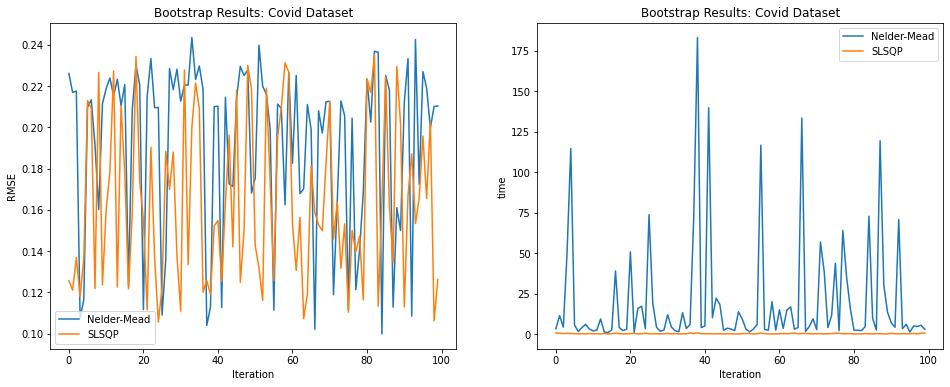

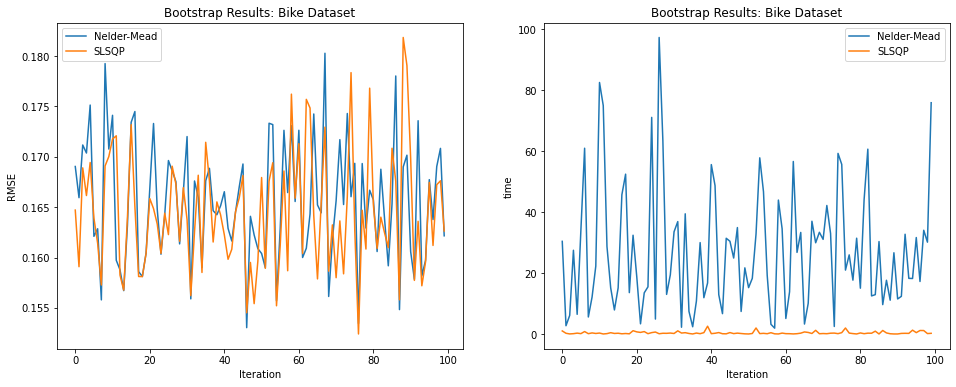

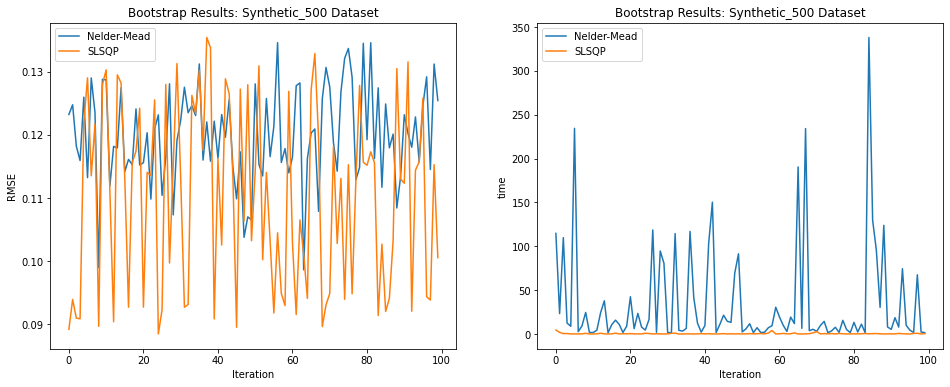

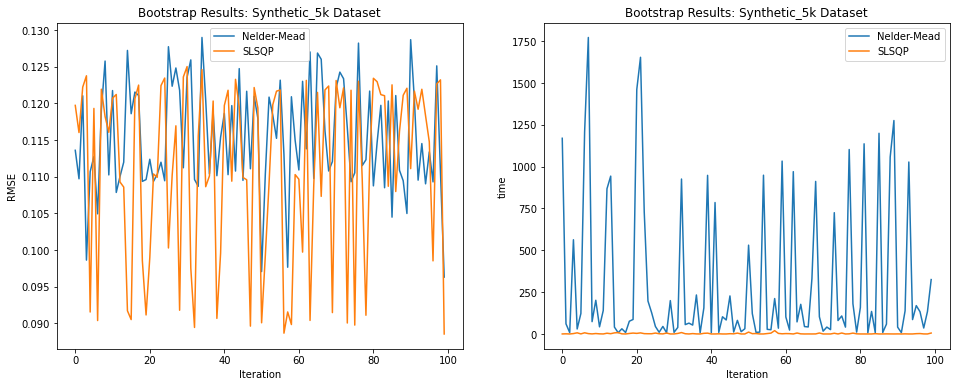

In [8]:
for dataset in datasets:
    df_best = pd.DataFrame.from_dict(dataset['results'][0], orient='index')
    df_all = pd.DataFrame.from_records(dataset['results'][1])

    idx = df_all.groupby(['iteration'])['test-rmse'].transform(min) == df_all['test-rmse']
    df_bestPerIter = df_all[idx]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    ax1.set_title(f"Bootstrap Results: {dataset['name']} Dataset")
    ax1.set_ylabel('RMSE')
    ax1.set_xlabel('Iteration')
    for method in df_all.method.unique():
        ax1.plot(df_all[df_all['method']==method]['iteration'], df_all[df_all['method']==method]['test-rmse'])
    ax1.legend(df_all.method.unique())
    # plt.savefig('../visualizations/genetic_bootstrap_covid')

    idx = df_all.groupby(['iteration'])['time'].transform(min) == df_all['time']
    df_bestPerIter = df_all[idx]

    # fig, ax = plt.subplots(figsize=(8,6))
    ax2.set_title(f"Bootstrap Results: {dataset['name']} Dataset")
    ax2.set_ylabel('time')
    ax2.set_xlabel('Iteration')
    for method in df_all.method.unique():
        ax2.plot(df_allfor dataset in datasets:
    df_best = pd.DataFrame.from_dict(dataset['results'][0], orient='index')
    df_all = pd.DataFrame.from_records(dataset['results'][1])[df_all['method']==method]['iteration'], df_all[df_all['method']==method]['time'])
    ax2.legend(df_all.method.unique())

In [11]:
df_all[df_all['method'] == 'Nelder-Mead'].describe()

iteration   test-rmse    numKnots  iterations         time
count  100.000000  100.000000  100.000000  100.000000   100.000000
mean    49.500000    0.115319    1.830000  179.860000   309.761351
std     29.011492    0.007401    0.817177   99.184251   441.475200
min      0.000000    0.096300    1.000000   46.000000     6.628196
25%     24.750000    0.110103    1.000000   87.500000    31.224132
50%     49.500000    0.113698    2.000000  168.000000    86.376825
75%     74.250000    0.121195    2.000000  249.000000   326.544105
max     99.000000    0.128992    4.000000  430.000000  1771.729373

In [12]:
df_all[df_all['method'] == 'SLSQP'].describe()

iteration   test-rmse    numKnots  iterations        time
count  100.000000  100.000000  100.000000    100.0000  100.000000
mean    49.500000    0.111149    2.240000     88.8500    2.173899
std     29.011492    0.012261    1.240072     78.0878    3.023420
min      0.000000    0.088540    1.000000      8.0000    0.035784
25%     24.750000    0.099678    1.000000     30.0000    0.125918
50%     49.500000    0.116038    2.000000     63.0000    0.911990
75%     74.250000    0.121799    3.000000    130.0000    3.138670
max     99.000000    0.125017    6.000000    363.0000   20.044535